In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
saas=pd.read_csv('saas.csv')

In [3]:
saas.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
saas['Month_Invoiced']=pd.to_datetime(saas['Month_Invoiced'])

In [5]:
saas=saas.set_index('Month_Invoiced')

In [6]:
saas.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [7]:
saas=saas.sort_index()
saas

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [8]:
saas.shape

(790458, 4)

# Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.

In [9]:
saas=pd.DataFrame(saas.resample('M')['Amount'].sum())
#df_resampled = df.resample('d')[['quantity','sales_total']].sum()

In [10]:
test_size=.90
val_size=.70
n=saas.shape[0]
test_start_index=round(test_size * n)
val_start_index=round(val_size*n)

train=saas[:val_start_index]
val=saas[val_start_index:test_start_index]
test=saas[test_start_index:]


print(train.shape, val.shape, test.shape)

(34, 1) (9, 1) (5, 1)


In [11]:
train

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


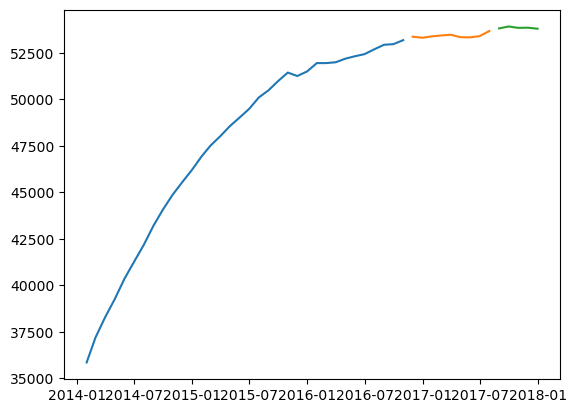

In [12]:
plt.plot(train.index, train['Amount'])
plt.plot(val.index, val['Amount'])
plt.plot(test.index, test['Amount'])

# Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
*Based on previous year/month/etc., this is up to you.

In [13]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(val[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(val[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title('Monthly Amount')
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [14]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [15]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last observed value

In [16]:
last_amount=train['Amount'][-1:][0]

In [17]:
yhat_df = pd.DataFrame({'Amount': [last_amount]},index=val.index)

yhat_df.head()

,Amount
Month_Invoiced,
2016-11-30,53190.0
2016-12-31,53190.0
2017-01-31,53190.0
2017-02-28,53190.0
2017-03-31,53190.0


Amount -- RMSE: 253


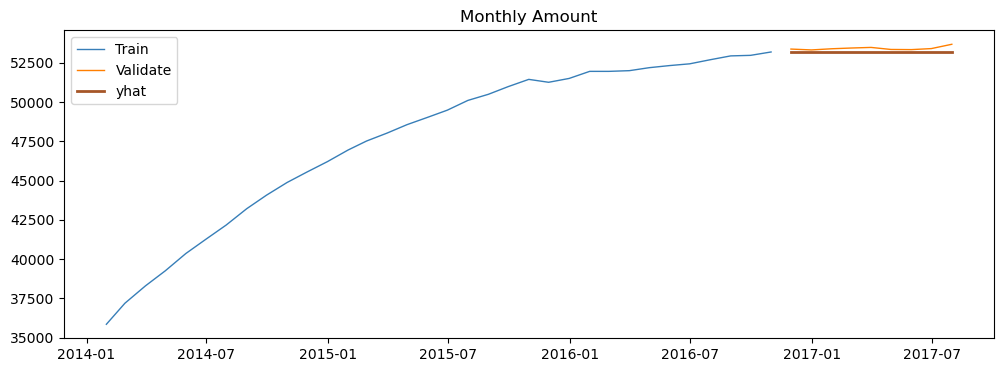

In [18]:
plot_and_eval('Amount')

In [19]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'Amount')

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,253.0


# Simple average

In [20]:
avg_amount=round(train['Amount'].mean(),2)
avg_amount

47597.21

In [26]:
def make_baseline_predictions(amount_prediction=None):
    yhat_df = pd.DataFrame({'Amount': [amount_prediction]}, index=val.index)
    return yhat_df

In [27]:
yhat_df=make_baseline_predictions(avg_amount)

In [28]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-11-30,47597.21
2016-12-31,47597.21
2017-01-31,47597.21
2017-02-28,47597.21
2017-03-31,47597.21


Amount -- RMSE: 5824


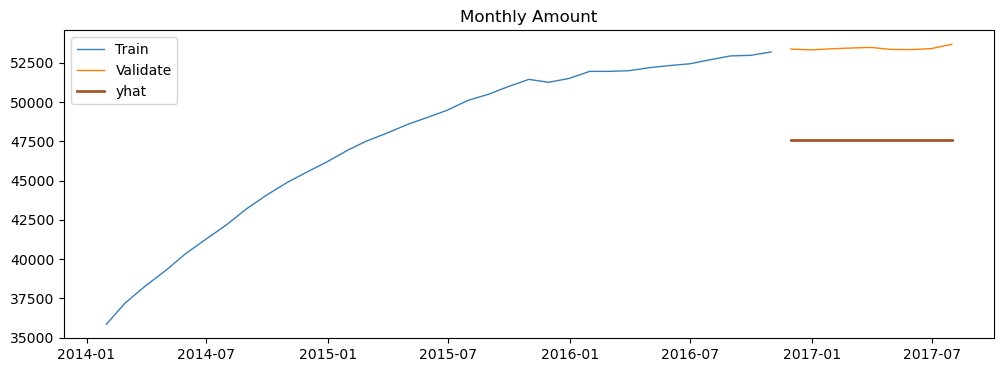

In [31]:
plot_and_eval('Amount')

In [32]:
eval_df= append_eval_df(model_type='simple_average', target_var='Amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,253.0
1,simple_average,Amount,5824.0
